In [1]:
import general
from caching import update_required, prep, save, load_previous
import sys

prep()

In [2]:
SEED = 2
REPS = 16

In [3]:
def size_provider():
    yield 0  # required for benchmark to determine total size of datasets
    i = 1
    while 1:
        yield round(i)
        i *= 4/3
        if i > 10000:
            break


In [4]:
datasets = general.generate_testing_data(list(size_provider()), REPS, SEED, quiet=2)
edges = general.generate_edge_cases(list(size_provider()), quiet=2)

results = {}
edge_results = {}

Generating testing data. This may take a while.
Need to generate 544 total datasets
generated 544 datasets in 0.51s                                                                     
Generating edge cases.
Generators:
   - sorted
   - reversed
   - all_eq
done, took 0.08s                                                                                    


In [5]:
def autorun_or_cache(f, fname, datasets, seed, quiet=1):
    if update_required(fname, seed):
        print(f'Cache missed for {fname}')
        try:
            result = general.bench(f, datasets, quiet=quiet)
            save(fname, seed, result)
            print(f'Saved {fname} to cache')
        except RecursionError:
            print(f'!! Recursion depth limit reached - cancelling !!')
            return 0, 0
        return result
    else:
        print(f'Cache hit for {fname}')
        print(f'Retrieving {fname} from cache')
        return load_previous(fname, seed)

In [6]:
def run_edge_cases(f, fname, edges, seed, quiet=1):
    result = {}
    for k, v in edges.items():
        result[k] = autorun_or_cache(f, fname + "_edge_" + k, v, seed, quiet)
    print("Done!")
    return result

In [7]:
def bubble(a: list):
    chks = 0
    swps = 0
    data = copy.copy(a)
    n = len(data)
    while 1:
        swapped = False
        for i in range(n-1):
            chks += 1
            if data[i] > data[i+1]:
                general.swp(data, i, i+1)
                swapped = True
                swps += 1
        if not swapped: break
    return data, swps, chks

In [8]:
results['bubble'] = autorun_or_cache(bubble, "bubble", datasets, SEED, quiet=1)
edge_results['bubble'] = run_edge_cases(bubble, "bubble", edges, SEED, quiet=1)
# s1, c1 = {}, {}

Cache hit for bubble
Retrieving bubble from cache
Cache hit for bubble_edge_sorted
Retrieving bubble_edge_sorted from cache
Cache hit for bubble_edge_reversed
Retrieving bubble_edge_reversed from cache
Cache hit for bubble_edge_all_eq
Retrieving bubble_edge_all_eq from cache
Done!


In [9]:
def selection(a: list):
    chks = 0
    swps = 0
    data = copy.copy(a)
    n = len(data)
    for i in range(n):
        m = i
        for j in range(i+1, n):
            chks += 1
            if data[m] >= data[j]:
                m = j
        swps += 1
        general.swp(data, i, m)
    return data, swps, chks

In [10]:
results['selection'] = autorun_or_cache(selection, "selection", datasets, SEED, quiet=1)
edge_results['selection'] = run_edge_cases(selection, "selection", edges, SEED, quiet=1)

Cache hit for selection
Retrieving selection from cache
Cache hit for selection_edge_sorted
Retrieving selection_edge_sorted from cache
Cache hit for selection_edge_reversed
Retrieving selection_edge_reversed from cache
Cache hit for selection_edge_all_eq
Retrieving selection_edge_all_eq from cache
Done!


In [11]:
def insertion(a: list):
    chks = 0
    swps = 0
    data = copy.copy(a)
    n = len(data)
    v = None
    j = None
    for x in range(1, n):
        v = data[x]
        j = x
        chks += 1
        while data[j-1] > v and j > 0:
            j -= 1
            chks += 1
        swps += 1
        data.pop(x)
        data.insert(j, v)
    return data, swps, chks

In [12]:
results['insertion'] = autorun_or_cache(insertion, "insertion", datasets, SEED, quiet=1)
edge_results['insertion'] = run_edge_cases(insertion, "insertion", edges, SEED, quiet=1)

Cache hit for insertion
Retrieving insertion from cache
Cache hit for insertion_edge_sorted
Retrieving insertion_edge_sorted from cache
Cache hit for insertion_edge_reversed
Retrieving insertion_edge_reversed from cache
Cache hit for insertion_edge_all_eq
Retrieving insertion_edge_all_eq from cache
Done!


In [13]:
def shellsort(a: list):
    chks = 0
    swps = 0
    data = copy.copy(a)
    n = len(data)
    h = 1
    while h <= n/9:
        h = int(3*h + 1)
    while h > 0:
        for i in range(h, n):
            v = data[i]
            j = i
            chks += 1
            while data[j-h] > v and j >= h:
                j -= h
                chks += 1
            swps += 1
            data.pop(i)
            data.insert(j, v)
        h = int(h/3)
    return data, swps, chks

In [14]:
results['shellsort'] = autorun_or_cache(shellsort, "shellsort", datasets, SEED, quiet=1)
edge_results['shellsort'] = run_edge_cases(shellsort, "shellsort", edges, SEED, quiet=1)

Cache hit for shellsort
Retrieving shellsort from cache
Cache hit for shellsort_edge_sorted
Retrieving shellsort_edge_sorted from cache
Cache hit for shellsort_edge_reversed
Retrieving shellsort_edge_reversed from cache
Cache hit for shellsort_edge_all_eq
Retrieving shellsort_edge_all_eq from cache
Done!


In [15]:
def quicksort(a: list, left: int = 0, right: int = None, depth: int = 0):
    if depth * 2 > 2000:
        # IPython crashes on Windows if the recursion limit is exceeded.
        raise RecursionError(f'Recursion limit will be exceeded ({depth} branch depth) halting before crash')
    n = len(a)
    if right is None:
        right = n - 1
    chks = 0
    swps = 0

    chks += 1
    if right - left < 1:
        # Do we even need to do work here?
        return a, swps, chks

    # partitioning
    pivot = a[right]
    q = left
    j = left
    for _ in range(left, right):
        target = a[j]
        chks += 1
        if target <= pivot:
            swp(a, j, q)
            swps += 1
            q += 1
        j += 1
        if j == right:
            break

    swp(a, right, q)
    # Q is the partition point.

    # Recursively apply quicksort to the left and right partitions
    a, _1, _2 = quicksort(a, left, q - 1, depth + 1)
    a, _3, _4 = quicksort(a, q + 1, right, depth + 1)
    chks += _1
    chks += _3
    swps += _2
    swps += _4
    return a, swps, chks

In [16]:
results['quicksort'] = autorun_or_cache(quicksort, "quicksort", datasets, SEED, quiet=2)
edge_results['quicksort'] = run_edge_cases(quicksort, "quicksort", edges, SEED, quiet=2)

Cache hit for quicksort
Retrieving quicksort from cache
Cache hit for quicksort_edge_sorted
Retrieving quicksort_edge_sorted from cache
Cache hit for quicksort_edge_reversed
Retrieving quicksort_edge_reversed from cache
Cache hit for quicksort_edge_all_eq
Retrieving quicksort_edge_all_eq from cache
Done!


In [17]:
def merge(a: list, b: list):
    result = []
    checks = 0
    swaps = 0
    while len(a) > 0 and len(b) > 0:
        checks += 1
        if a[0] < b[0]:
            result.append(a.pop(0))
        else:
            result.append(b.pop(0))
        swaps += 1

    # Consume rest
    while len(a) > 0:
        result.append(a.pop(0))
        swaps += 1
    while len(b) > 0:
        result.append(b.pop(0))
        swaps += 1
    return result, checks, swaps


def mergesort(m: list):
    if len(m) <= 1:
        return m, 0, 0

    left = []
    right = []
    for i, x in enumerate(m):
        if i < len(m) // 2:
            left.append(x)
        else:
            right.append(x)

    left, c1, s1 = mergesort(left)
    right, c2, s2 = mergesort(right)

    r, c3, s3 = merge(left, right)

    checks = c1 + c2 + c3
    swaps = s1 + s2 + s3
    return r, checks, swaps

In [18]:
results['mergesort'] = autorun_or_cache(mergesort, "mergesort", datasets, SEED, quiet=1)
edge_results['mergesort'] = run_edge_cases(mergesort, "mergesort", edges, SEED, quiet=1)

Cache hit for mergesort
Retrieving mergesort from cache
Cache hit for mergesort_edge_sorted
Retrieving mergesort_edge_sorted from cache
Cache hit for mergesort_edge_reversed
Retrieving mergesort_edge_reversed from cache
Cache hit for mergesort_edge_all_eq
Retrieving mergesort_edge_all_eq from cache
Done!


In [19]:
import matplotlib.pyplot as plt

In [20]:
def axis_config(ax, xlabel, ylabel):
    # disable scientific notation and offsets
    ax.ticklabel_format(useOffset=False, style='plain')
    
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)

In [21]:
# unpack results data
def unpack_results(data, ax0, ax1, which: list = None):
    for k, v in data.items():
        if which is not None and k not in which: continue
        s, c = v
        ax0.plot(c.keys(), c.values(), label=k)
        ax1.plot(s.keys(), s.values(), label=k)
    ax0.set_title(f"checks")
    axis_config(ax0, "Dataset Size (N)", "Mean Check Count")
    ax1.set_title(f"swaps")
    axis_config(ax1, "Dataset Size (N)", "Mean Swap Count")
    ax0.legend()
    ax1.legend()

In [22]:
# unpack a single result (like 'bubble')
def unpack_edges(sort_data, ax0, ax1):
    for k, v in sort_data.items():
        s, c = v
        ax0.plot(c.keys(), c.values(), label=k)
        ax1.plot(s.keys(), s.values(), label=k)

def unpack_all_edges(edata, rdata):
    axes = []
    for sort_name, data in edata.items():
        fig0, ax0 = plt.subplots()
        fig1, ax1 = plt.subplots()
        unpack_edges(data, ax0, ax1)
        s, c = rdata[sort_name]
        
        ax0.plot(c.keys(), c.values(), label="random")
        ax0.set_title(f"{sort_name} checks")
        axis_config(ax0, "Dataset Size (N)", "Mean Check Count")
        
        ax1.plot(s.keys(), s.values(), label="random")
        ax1.set_title(f"{sort_name} swaps")
        axis_config(ax1, "Dataset Size (N)", "Mean Swap Count")
        
        ax0.legend()
        ax1.legend()
        axes.append(ax0)
        axes.append(ax1)
    return axes

[<AxesSubplot:title={'center':'bubble checks'}, xlabel='Dataset Size (N)', ylabel='Mean Check Count'>,
 <AxesSubplot:title={'center':'bubble swaps'}, xlabel='Dataset Size (N)', ylabel='Mean Swap Count'>,
 <AxesSubplot:title={'center':'selection checks'}, xlabel='Dataset Size (N)', ylabel='Mean Check Count'>,
 <AxesSubplot:title={'center':'selection swaps'}, xlabel='Dataset Size (N)', ylabel='Mean Swap Count'>,
 <AxesSubplot:title={'center':'insertion checks'}, xlabel='Dataset Size (N)', ylabel='Mean Check Count'>,
 <AxesSubplot:title={'center':'insertion swaps'}, xlabel='Dataset Size (N)', ylabel='Mean Swap Count'>,
 <AxesSubplot:title={'center':'shellsort checks'}, xlabel='Dataset Size (N)', ylabel='Mean Check Count'>,
 <AxesSubplot:title={'center':'shellsort swaps'}, xlabel='Dataset Size (N)', ylabel='Mean Swap Count'>,
 <AxesSubplot:title={'center':'quicksort checks'}, xlabel='Dataset Size (N)', ylabel='Mean Check Count'>,
 <AxesSubplot:title={'center':'quicksort swaps'}, xlabel='Da

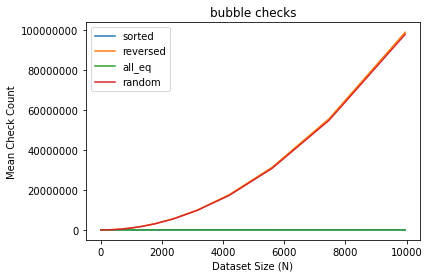

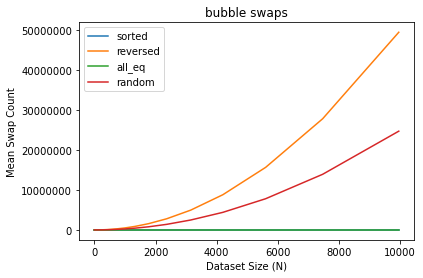

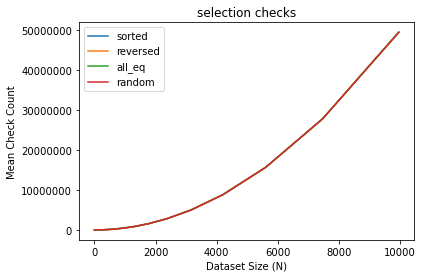

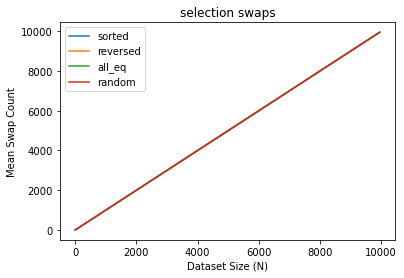

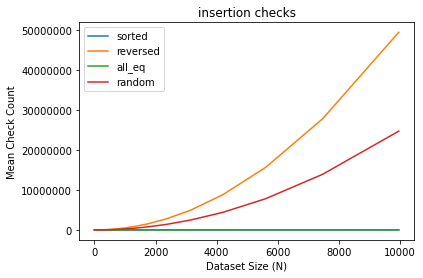

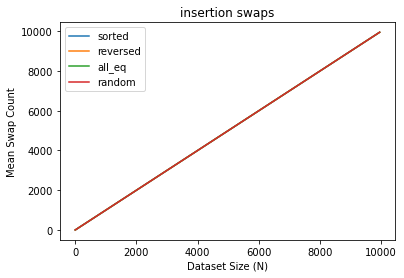

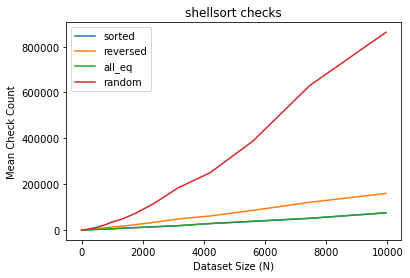

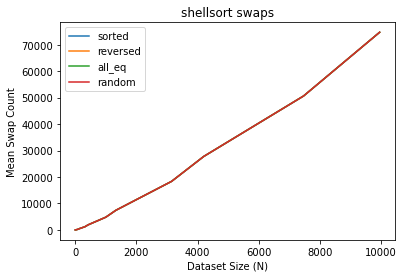

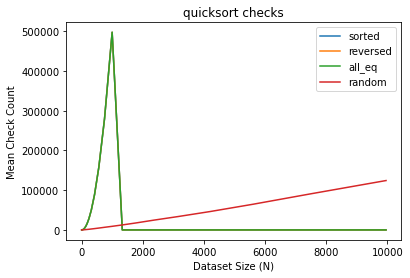

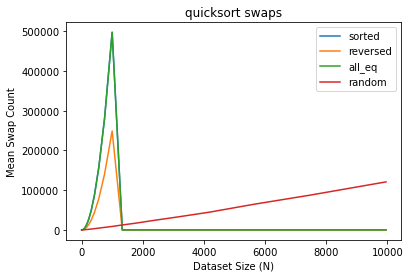

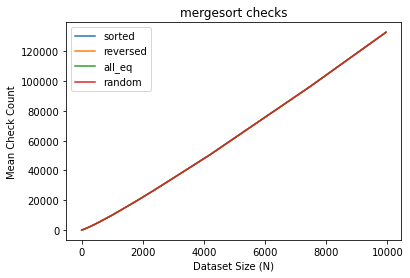

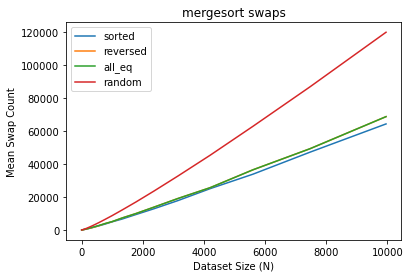

In [23]:
unpack_all_edges(edge_results, results)
# scroll this box to see all the fancy graphs

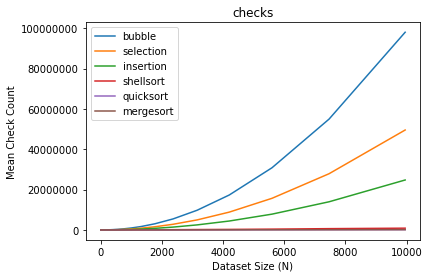

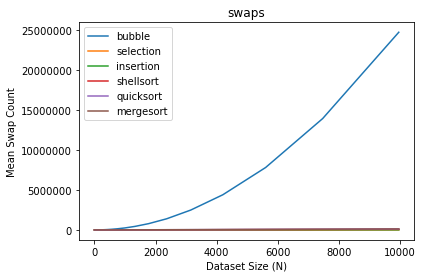

In [24]:
fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
unpack_results(results, ax0, ax1)

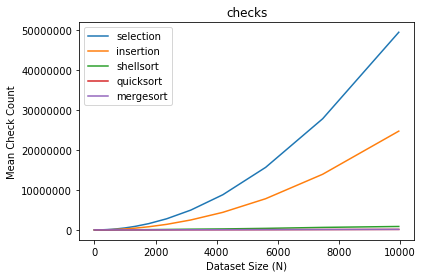

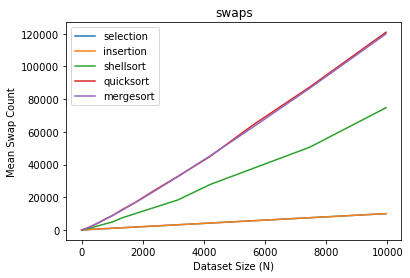

In [25]:
# no bubble sort
fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
unpack_results(results, ax0, ax1, ['selection', 'insertion', 'shellsort', 'quicksort', 'mergesort'])

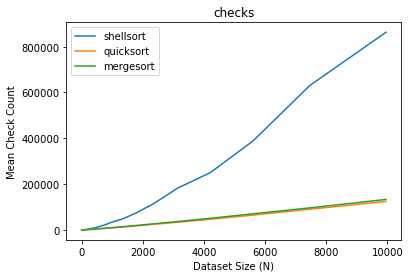

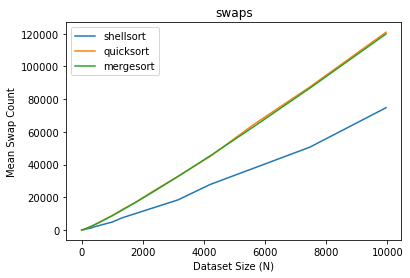

In [26]:
# no selection, insertion sort
fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
unpack_results(results, ax0, ax1, ['shellsort', 'quicksort', 'mergesort'])

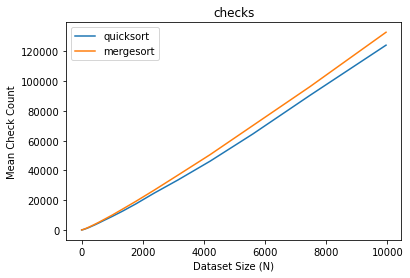

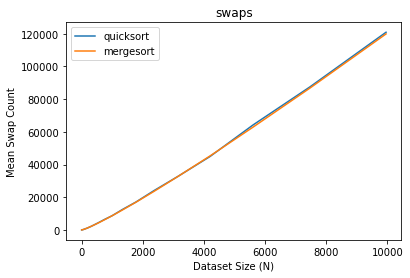

In [27]:
# no shellsort
fig0, ax0 = plt.subplots()
fig1, ax1 = plt.subplots()
unpack_results(results, ax0, ax1, ['quicksort', 'mergesort'])